In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df= pd.read_csv('bikeshare_train_data.csv')
df.sample(5)

,Date,day_length,min_temp,max_temp,mean_temp,temp_diff,hdd,cdd,rain,snow,total_precip,snow_on_ground,max_gust,mean_dep_temp,mean_ret_temp,mean_ride_temp,total_dist,total_duration,ebike_trips,num_trips
501,2018-05-17,925.250000,11.8,18.2,15.0,6.4,3.0,0.0,0.0,0.0,0.0,0.0,1.0,19.776475,20.267426,20.021950,8734031.67,4061884.0,0.0,2984
1064,2019-12-01,510.133333,-5.0,4.4,-0.3,9.4,18.3,0.0,6.4,0.0,6.4,0.0,0.0,5.419069,6.440133,5.929601,2161227.00,942761.0,0.0,902
707,2018-12-09,498.133333,2.9,7.0,5.0,4.1,13.0,0.0,18.8,0.0,18.8,0.0,10.0,8.362205,9.594488,8.978346,505696.00,157508.0,0.0,254
581,2018-08-05,895.233333,15.4,25.4,20.4,10.0,0.0,2.4,0.0,0.0,0.0,0.0,-1.0,27.984670,27.764262,27.874466,13347195.67,8151699.0,0.0,3979
1709,2021-09-06,787.216667,12.7,21.4,17.1,8.7,0.9,0.0,0.0,0.0,0.0,0.0,0.0,23.780789,23.471842,23.626316,11141959.33,5195522.0,0.0,3800


In [3]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

In [4]:
X_train = df[['total_precip','mean_dep_temp']]
y_train = df['num_trips']

X_tt,X_val, y_tt,y_val = train_test_split(X_train, y_train, shuffle = True, random_state = 416, test_size = .2)

In [5]:
# Define some baseline models
reg = LinearRegression()
knr10 = KNeighborsRegressor(10)

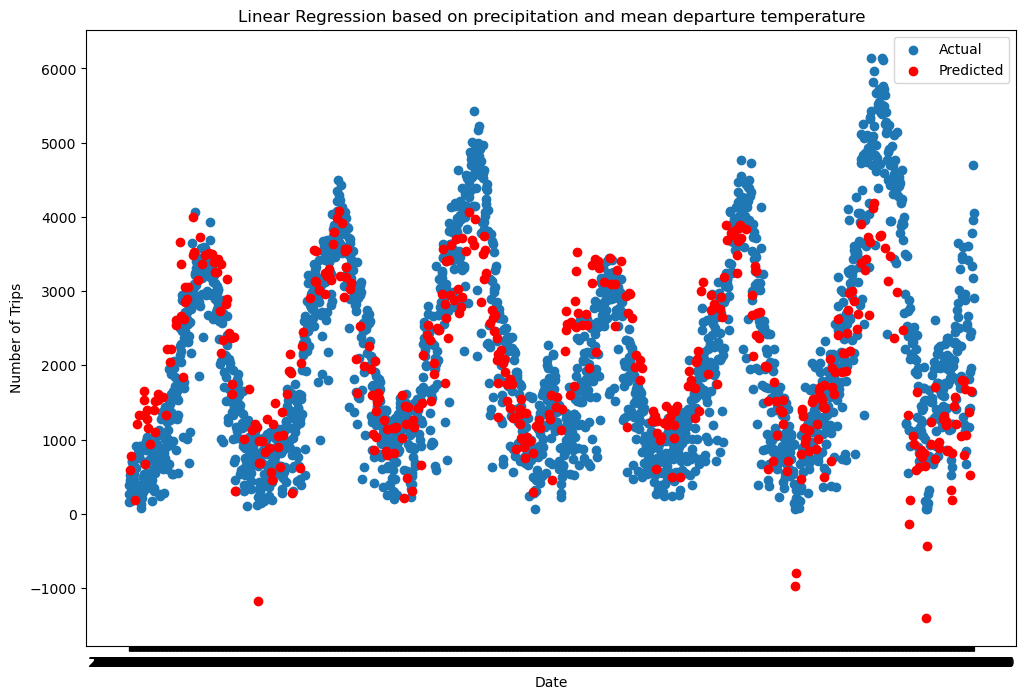

In [6]:
# Do a linear regression (without cross validation)
reg.fit(X_tt,y_tt)
y_pred = reg.predict(X_val)

# Plotting the actual vs. predicted values
plt.figure(figsize=(12, 8))
plt.scatter(df['Date'], df['num_trips'], label='Actual', linestyle='-')
plt.scatter(df['Date'][y_val.index], y_pred, label='Predicted', color='red')
plt.xlabel('Date')
plt.ylabel('Number of Trips')
plt.title('Linear Regression based on precipitation and mean departure temperature')
plt.legend()
plt.show()

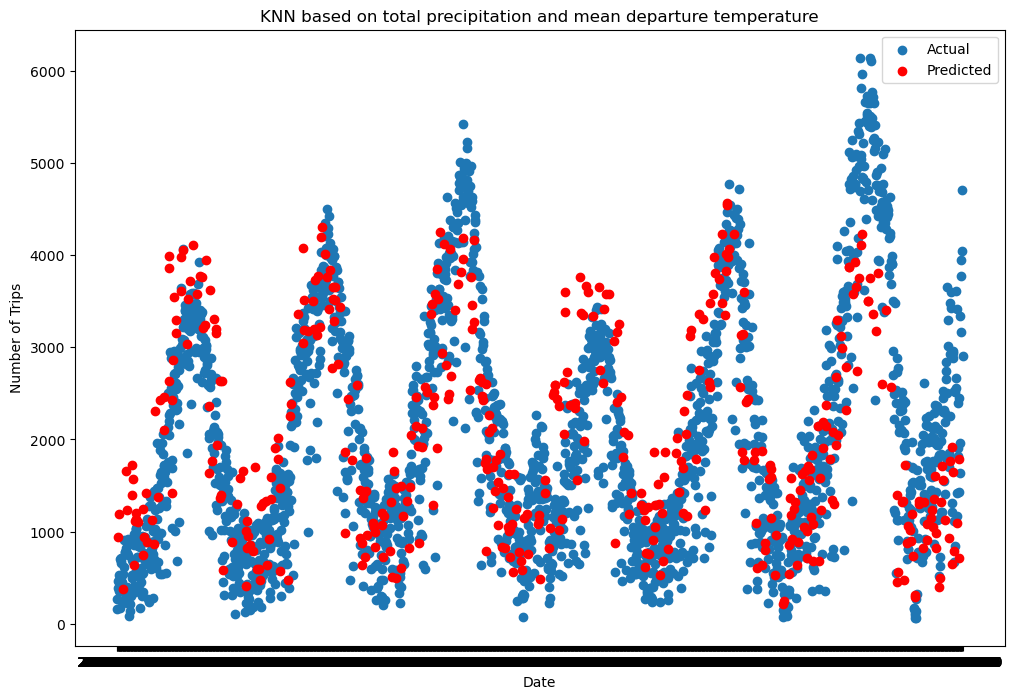

In [7]:
# Do a KNN (without cross validation)
knr10.fit(X_tt,y_tt)
y_pred2 = knr10.predict(X_val)

# Plotting the actual vs. predicted values
plt.figure(figsize=(12, 8))
plt.scatter(df['Date'], df['num_trips'], label='Actual', linestyle='-')
plt.scatter(df['Date'][y_val.index], y_pred2, label='Predicted', color='red')
plt.xlabel('Date')
plt.ylabel('Number of Trips')
plt.title('KNN based on total precipitation and mean departure temperature')
plt.legend()
plt.show()

In [8]:
# Testing a model using n cross validations, return the average mse
def test(model, n):
    
    kfold = KFold(n_splits = n,shuffle = True, random_state = 416)
    total_mse = 0
    
    for train_index, test_index in kfold.split(X_train, y_train):
    
        X_tt = X_train.iloc[train_index]
        y_tt = y_train.iloc[train_index]
    
        X_val = X_train.iloc[test_index]
        y_val = y_train.iloc[test_index]
    
        ## Fit the model
        model.fit(X_tt,y_tt)

        # Make the prediction
        y_pred = reg.predict(X_val)
        mse = mean_squared_error(y_val, y_pred)

        total_mse += mse
    
    return total_mse/n

In [9]:
test(reg,5)

490797.0433864746

In [10]:
test(knr10,5)

489711.5566822436